### Impor Library

Blok kode ini mengimpor library Python yang diperlukan untuk membangun dan melatih model deteksi emosi, termasuk PyTorch untuk deep learning, torchvision untuk penanganan dataset gambar, dan matplotlib untuk visualisasi.

In [64]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Transformasi Data

Blok kode ini mendefinisikan transformasi yang akan diterapkan pada data gambar untuk pelatihan dan pengujian. Ini termasuk mengubah ukuran gambar, augmentasi data (horizontal flip acak, rotasi acak), mengubah gambar menjadi skala abu-abu, mengonversinya menjadi tensor, dan menormalisasi piksel.

In [65]:
# Transformasi data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Memuat Dataset

Blok kode ini mendefinisikan path ke dataset pelatihan dan pengujian, memverifikasi path tersebut, dan kemudian memuat dataset menggunakan `ImageFolder` dari torchvision. Ini juga mencetak informasi tentang dataset, seperti jumlah kelas, nama kelas, dan jumlah gambar di setiap set.

In [66]:
# Perbaikan path dataset - sesuaikan dengan struktur folder Anda
base_dir = os.path.expanduser('~/Documents/emodetec/dataemo')  # Path ke folder utama
train_dir = os.path.join(base_dir, 'train')  # Path ke folder train
test_dir = os.path.join(base_dir, 'test')    # Path ke folder test

# Verifikasi path
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

# Load dataset dengan path yang benar

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    
print(f"Jumlah kelas: {len(train_dataset.classes)}")
print(f"Nama kelas: {train_dataset.classes}")
print(f"Jumlah gambar training: {len(train_dataset)}")
print(f"Jumlah gambar test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Train directory: /Users/syafiqbasmallah/Documents/emodetec/dataemo/train
Test directory: /Users/syafiqbasmallah/Documents/emodetec/dataemo/test
Jumlah kelas: 7
Nama kelas: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Jumlah gambar training: 28709
Jumlah gambar test: 7178


In [67]:
image, label = next(iter(train_loader))
print(image.shape)

torch.Size([64, 1, 48, 48])


In [68]:
image = image.squeeze().permute(0,1,2)
print(image.shape)


torch.Size([64, 48, 48])


### Visualisasi Distribusi Kelas

Blok kode ini menghitung dan memvisualisasikan distribusi kelas dalam dataset pelatihan dan pengujian menggunakan bar plot. Ini membantu memahami keseimbangan atau ketidakseimbangan kelas dalam data.

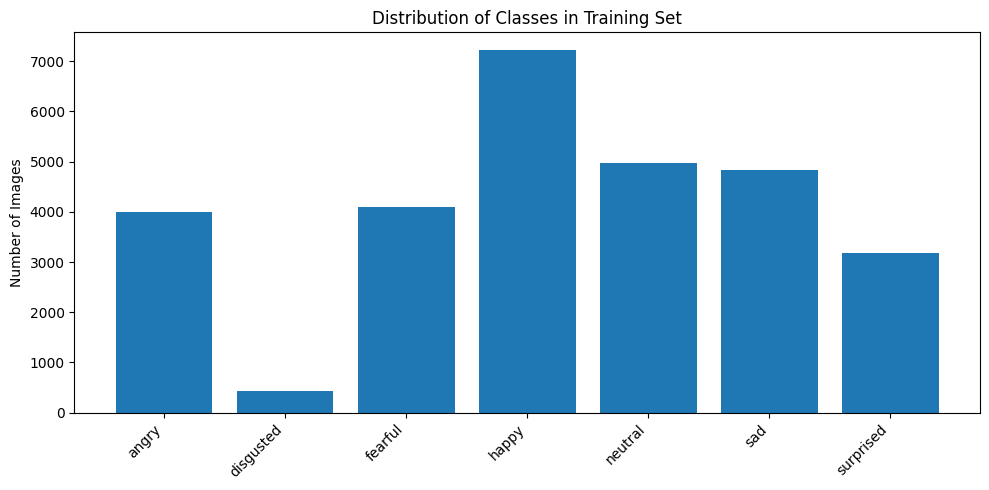

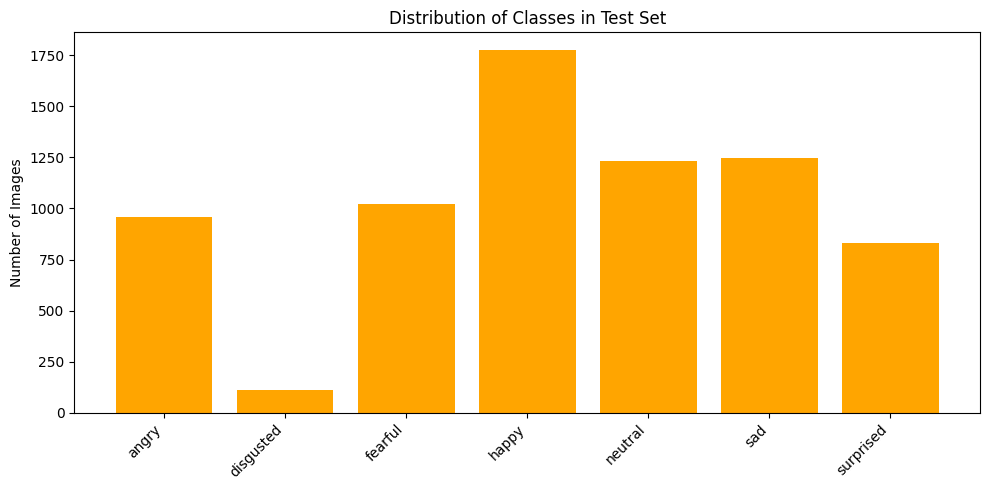

In [69]:

# Calculate class distribution for training set
train_class_counts = {}
for _, index in train_dataset.samples:
    label = train_dataset.classes[index]
    if label not in train_class_counts:
        train_class_counts[label] = 0
    train_class_counts[label] += 1

# Calculate class distribution for test set
test_class_counts = {}
for _, index in test_dataset.samples:
    label = test_dataset.classes[index]
    if label not in test_class_counts:
        test_class_counts[label] = 0
    test_class_counts[label] += 1

# Prepare data for visualization
classes = train_dataset.classes
train_counts = [train_class_counts[c] for c in classes]
test_counts = [test_class_counts[c] for c in classes]

# Create bar plot for training data
plt.figure(figsize=(10, 5))
plt.bar(classes, train_counts)
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Create bar plot for test data
plt.figure(figsize=(10, 5))
plt.bar(classes, test_counts, color='orange')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Test Set')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Menampilkan Contoh Gambar

Blok kode ini mendefinisikan fungsi `imshow` untuk membalikkan normalisasi dan menampilkan gambar. Kemudian menampilkan empat contoh gambar dari batch pertama data pelatihan.

Image shape: torch.Size([64, 1, 48, 48]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


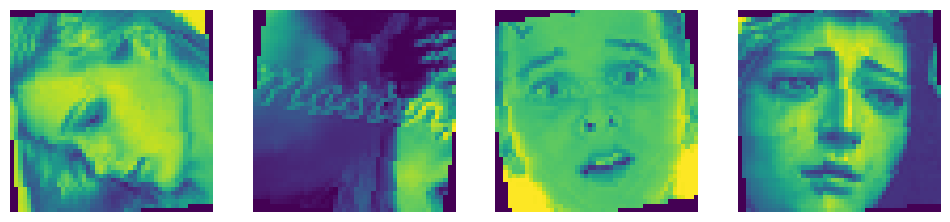

In [70]:
for images, labels in train_loader:
    print(f"Image shape: {images.shape} -> [batch_size, color_channels, height, width]")
    print(f"Label shape: {labels.shape}")
    break  # Remove this line if you want to print shapes for all batches

# Function to denormalize and show images
def imshow(img, ax):
    img = img.clone().detach().cpu()  # Ensure the image is on CPU
    img = img * 0.5 + 0.5  # Reverse normalization
    img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    ax.imshow(img)
    ax.axis("off")


# Display images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    imshow(images[i], axes[i])
plt.show()

### Mendefinisikan dan Melatih Model CNN

Blok kode ini mendefinisikan arsitektur Convolutional Neural Network (CNN) untuk deteksi emosi. Ini juga mendefinisikan fungsi loss (Cross-Entropy Loss) dan optimizer (Adam). Bagian utama dari blok ini adalah loop pelatihan, di mana model dilatih selama jumlah epoch yang ditentukan, dan kinerja dievaluasi pada set pelatihan dan pengujian di setiap epoch. Model terbaik berdasarkan akurasi pengujian disimpan.

In [ ]:
# Arsitektur CNN
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ELU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ELU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ELU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Flatten(), # Flatten the output for the linear layers
    nn.Linear(128 * 6 * 6, 256),
    nn.ELU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 7) # Output layer with 7 classes
).to(device)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Pelatihan model
num_epochs = 25
best_accuracy = 0.0
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluasi
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / test_total
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Save model terbaik
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')


# Visualisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

Epoch [1/25] | Train Loss: 1.8293 | Train Acc: 28.56% | Test Loss: 1.5454 | Test Acc: 40.71%
Epoch [2/25] | Train Loss: 1.5452 | Train Acc: 39.21% | Test Loss: 1.3995 | Test Acc: 45.33%
Epoch [3/25] | Train Loss: 1.4427 | Train Acc: 44.05% | Test Loss: 1.3281 | Test Acc: 48.51%


### Evaluasi Model (Classification Report)

Blok kode ini menggunakan pustaka scikit-learn untuk menghasilkan classification report yang komprehensif pada set pengujian. Laporan ini mencakup metrik seperti presisi, recall, f1-score, dan support untuk setiap kelas, serta akurasi keseluruhan.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Set the model to evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Iterate over the test set and collect predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Get class names from the dataset
class_names = test_dataset.classes

# Generate and print the classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

### Evaluasi Akurasi Model (Per-Class dan Overall)

Blok kode ini mendefinisikan fungsi untuk menghitung dan mencetak akurasi keseluruhan dan per-kelas untuk set pelatihan dan pengujian. Ini memberikan pandangan yang lebih rinci tentang kinerja model pada setiap kategori emosi.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Function to calculate and print accuracy
def evaluate_model_accuracy(loader, dataset, device, data_type):
    total = 0
    correct = 0
    class_correct = list(0. for i in range(len(dataset.classes)))
    class_total = list(0. for i in range(len(dataset.classes)))

    with torch.no_grad():
        for batch_features, batch_labels in loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()

            # Corrected indentation for the following lines
            c = (predicted == batch_labels).squeeze()
            for i in range(batch_labels.shape[0]):
                label = batch_labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    overall_accuracy = correct / total if total > 0 else 0
    print(f'Overall {data_type} Accuracy: {overall_accuracy:.4f} ({correct}/{total})')


    print(f'\nPer-Class {data_type} Accuracy:')
    class_names = dataset.classes
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f'  Accuracy of {class_names[i]:10s}: {class_accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
        else:
            print(f'  Accuracy of {class_names[i]:10s}: N/A (no samples)')

# Evaluate training accuracy
evaluate_model_accuracy(train_loader, train_dataset, device, "Training")

# Evaluate test accuracy
evaluate_model_accuracy(test_loader, test_dataset, device, "Test")

